# Crypto Currency Time Series Project

This notebook aims to deliver a tuned Prophet model capable of predicting price values of some of the most famous  
crypto currencies based on the past data

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Define API Params

First define the coin to predict, actual date and a past date of n years in the past.   
Lastly define other API params such as currency and number of decimals.

In [2]:
coin = 'ethereum'

In [3]:
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'

In [4]:
years = 4

In [5]:
today = int(datetime.datetime.now().timestamp())

In [6]:
past_date = int((datetime.datetime.now() - datetime.timedelta(days=365 * years)).timestamp())

In [7]:
params = {'vs_currency': 'usd',
          'from': past_date,
          'to': today,
          'precision': 2}

In [8]:
response = requests.get(url, params=params).json()

In [9]:
df = pd.DataFrame(response["prices"], columns=["Timestamp", "Price"])
df.head()

,Timestamp,Price
0,1574208000000,175.82
1,1574294400000,174.80
2,1574380800000,161.15
3,1574467200000,149.93
4,1574553600000,151.97


# Data Cleaning 

Change the date table to a more human readable format, from Timestamp to yyyy-mm-dd

In [10]:
df['Date']= df['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

In [11]:
df['Timestamp'] = df['Date']

In [12]:
df.drop(columns=['Date'], inplace=True)

In [13]:
df.rename(columns={'Timestamp': 'Date'}, inplace=True)

In [14]:
df['Date']=pd.to_datetime(df['Date'])

In [15]:
df.head()

,Date,Price
0,2019-11-19,175.82
1,2019-11-20,174.80
2,2019-11-21,161.15
3,2019-11-22,149.93
4,2019-11-23,151.97


In [16]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

<AxesSubplot:title={'center':'ethereum trend'}, xlabel='Date', ylabel='Price'>

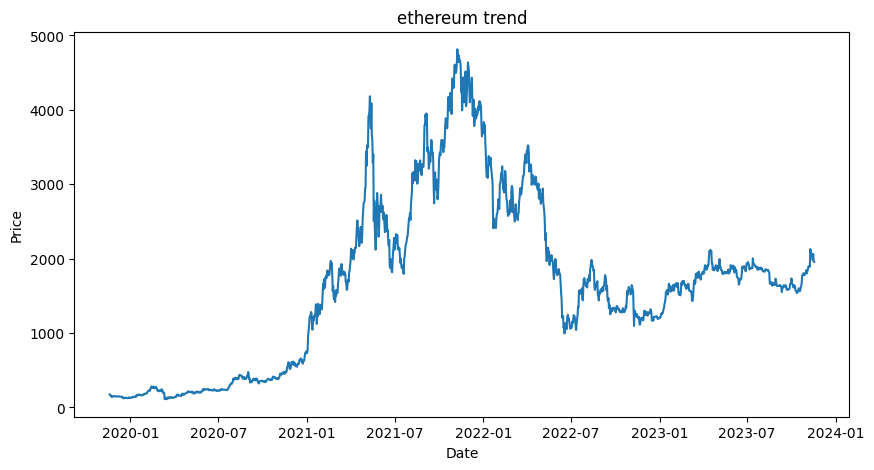

In [17]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend')
sns.lineplot(data=df, x='Date', y='Price')

# Prophet Model

## Preparing data for Prophet

In [18]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [19]:
df.rename(columns={'Date': 'ds',
                  'Price': 'y'}, inplace=True)

In [20]:
df.head()

,ds,y
0,2019-11-19,175.82
1,2019-11-20,174.80
2,2019-11-21,161.15
3,2019-11-22,149.93
4,2019-11-23,151.97


## Train Test Split

In [21]:
train_index = int(0.9*len(df))
train_index

1314

In [22]:
train = df.iloc[:train_index]
test = df.iloc[train_index:]

In [23]:
train.tail()

,ds,y
1309,2023-06-20,1790.19
1310,2023-06-21,1892.90
1311,2023-06-22,1874.18
1312,2023-06-23,1891.35
1313,2023-06-24,1875.06


In [24]:
test.head()

,ds,y
1314,2023-06-25,1899.15
1315,2023-06-26,1859.80
1316,2023-06-27,1890.01
1317,2023-06-28,1828.46
1318,2023-06-29,1853.45


## Instantiate Model & Forecast (for test set)

First we will instantiate the prophet model and fit it to our train data.  
After that we will predict just the same dates of our test set and compare them.

In [25]:
model = Prophet()

In [26]:
model.fit(train)

14:17:45 - cmdstanpy - INFO - Chain [1] start processing
14:17:45 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future_test = model.make_future_dataframe(periods=len(test))

In [28]:
future_test


,ds
0,2019-11-19
1,2019-11-20
2,2019-11-21
3,2019-11-22
4,2019-11-23
...,...
1455,2023-11-13
1456,2023-11-14
1457,2023-11-15
1458,2023-11-16


In [29]:
forecast_test = model.predict(future_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1455,2023-11-13,2056.467238,1552.131218,2587.490013
1456,2023-11-14,2052.163769,1553.097459,2579.953675
1457,2023-11-15,2052.340639,1555.868195,2561.844826
1458,2023-11-16,2039.684877,1499.418479,2564.257918
1459,2023-11-17,2028.698835,1485.448291,2526.292766


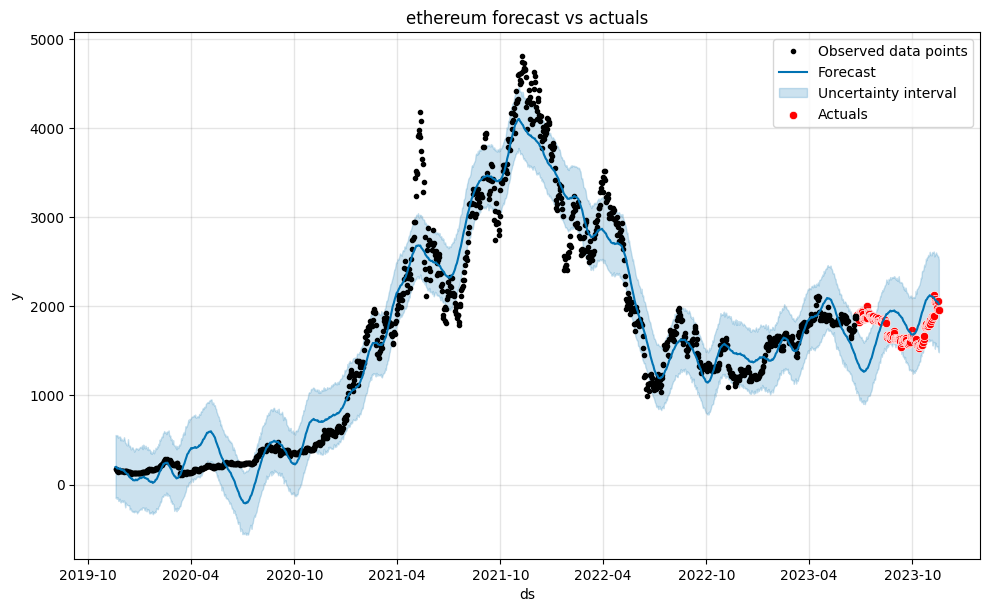

In [30]:
fig_1 = model.plot(forecast_test)

ax = plt.gca()
sns.scatterplot(x='ds', y='y', data=test, color='red', label='Actuals', ax=ax)

plt.legend()
plt.title(f'{coin} forecast vs actuals')

plt.show()

## Model Evaluation

### Simple Evaluation with Sklearn MAPE

In [31]:
predictions_test = forecast_test['yhat'].iloc[train_index:]

In [32]:
mape= mean_absolute_percentage_error(test['y'], predictions_test)
mape

0.15261852183296262

### Cross Validation Evaluation